<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 2

</h4>

# Personal Data

In [106]:
# Set your student number
student_number = 400104686
Name = 'Parsa'
Last_Name = 'Yousefpoor'

# Rules
- You are not allowed to add or remove cells. You **must use the provided space to write your code**. If you don't follow this rule, **your Practical Assignment won't be graded**.  

- Collaboration and using the internet is allowed, but your code **must be written by yourself**. **Copying code** from each other or from available resources will result in a **zero score for the assignment**.

- You are not allowed to use `torch.nn`, `torch.optim` and any activation function and loss function implemented in torch.

## Question 1) Convolutional Neural Networks ``(50 pt.)``

In this question, you'll be coding up a convolutional neural network from scratch to classify images using PyTorch.  

### Instructions
- Install PyTorch following the instructions [here](https://pytorch.org/).
- Install the [`torchinfo` package](https://github.com/TylerYep/torchinfo) to visualize the network architecture and the number of parameters. The maximum number of parameters you are allowed to use for your network is **100,000**.
- You are required to complete the functions defined in the code blocks following each question. Fill out sections of the code marked `"YOUR CODE HERE"`.
- You're free to add any number of methods within each class.
- You may also add any number of additional code blocks that you deem necessary.

### Data Preparation
In this assignment, we will use the Fashion-MNIST dataset. Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.  

#### Data

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255.  

#### Labels

Each training and test example is assigned to one of the following labels:

| Label | Description |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

Fashion-MNIST is included in the `torchvision` library.

In [107]:
# Import required packages
from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose, ToTensor, Normalize
import matplotlib.pyplot as plt
import numpy as np

In [108]:
# Transform to normalize the data and convert to a tensor
transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])

# Download the data
dataset = FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)

### Data Exploration
Let's take a look at the classes in our dataset.

In [109]:
print(dataset.classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Now, visualize an instance from each class.

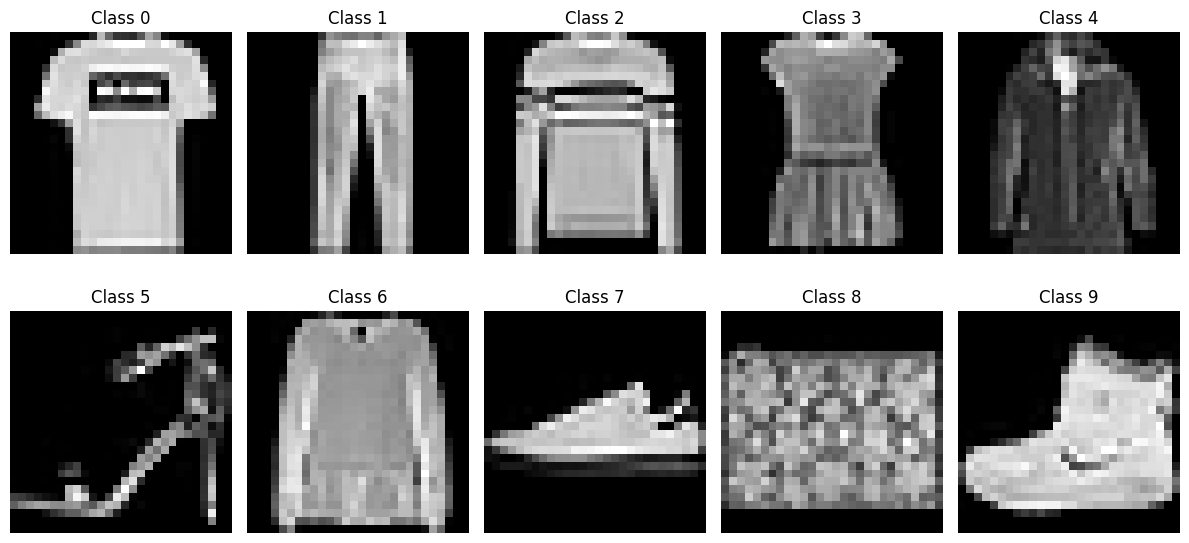

In [110]:
######################
#   YOUR CODE HERE   #
######################
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

# Get one sample per class
for i in range(10):
    # Find a sample of the current class
    sample_idx = np.where(np.array(dataset.targets) == i)[0][0]
    image, label = dataset[sample_idx]

    # Unnormalize the image
    image = image * 0.5 + 0.5

    # Plot the image
    ax = axes[i//5, i%5]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Class {label}')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Creating Training and Validation Datasets

The `split_indices` function takes in the size of the entire dataset, `n`, the fraction of data to be used as validation set, `val_frac`, and the random seed and returns the indices of the data points to be added to the validation dataset.

In [111]:
def split_indices(n, val_frac, seed):
    # Determine the size of the validation set
    n_val = int(val_frac * n)
    np.random.seed(seed)
    # Create random permutation between 0 to n-1
    idxs = np.random.permutation(n)
    # Pick first n_val indices for validation set
    return idxs[n_val:], idxs[:n_val]

In [112]:
######################
#   YOUR CODE HERE   #
######################
val_frac = 0.2 ## Set the fraction for the validation set
rand_seed = 42 ## Set the random seed

train_indices, val_indices = split_indices(len(dataset), val_frac, rand_seed)
print("number of samples in training set: {}".format(len(train_indices)))
print("number of samples in validation set: {}".format(len(val_indices)))

number of samples in training set: 48000
number of samples in validation set: 12000


Next, we make use of the built-in dataloaders in PyTorch to create iterables of our training and validation sets. This helps in avoiding fitting the whole dataset into memory and only loads a batch of the data that we can decide.

In [113]:
# Import required packages
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [114]:
######################
#   YOUR CODE HERE   #
######################
batch_size = 32 ## Set the batch size

# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset,
                     batch_size,
                     sampler=train_sampler)

# Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(dataset,
                   batch_size,
                   sampler=val_sampler)

Plot images in a sample batch of data.

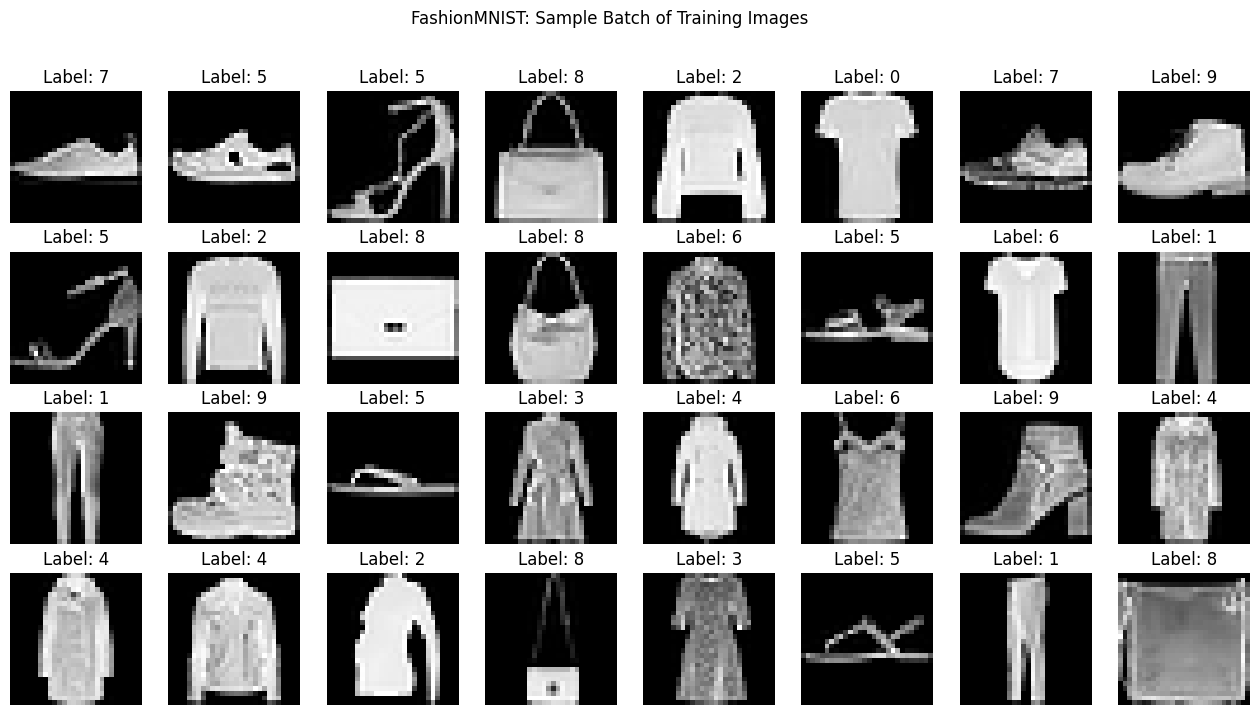

In [115]:
######################
#   YOUR CODE HERE   #
######################
# Get a batch of training data
for batch_images, batch_labels in train_dl:
    # batch_images is a tensor of shape (batch_size, 1, 28, 28)
    break  # Stop after the first batch

# Display the images
fig, axs = plt.subplots(4, 8, figsize=(16, 8))
fig.suptitle("FashionMNIST: Sample Batch of Training Images")

for i, ax in enumerate(axs.flat):
    ax.imshow(batch_images[i][0], cmap='gray')
    ax.set_title(f"Label: {batch_labels[i]}")
    ax.axis('off')

plt.show()

In [116]:
!pip install torchinfo

### Building the Model
Create your model by defining the network architecture in the `ImageClassifierNet` class.<br>
**NOTE:** The number of parameters in your network must be $\leq$ 100,000.

In [117]:
# Import required packages
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

In [118]:
class ImageClassifierNet(nn.Module):
    def __init__(self, n_channels=1):
        super(ImageClassifierNet, self).__init__()
        ######################
        #   YOUR CODE HERE   #
        ######################
        self.conv1 = nn.Conv2d(n_channels, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.adap_pool = nn.AdaptiveAvgPool2d((4, 4))
        self.fc1 = nn.Linear(32 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 10)
    def forward(self, X):
        ######################
        #   YOUR CODE HERE   #
        ######################
        X = self.pool(F.relu(self.conv1(X)))
        X = self.pool(F.relu(self.conv2(X)))
        X = self.pool(F.relu(self.conv3(X)))
        X = self.adap_pool(X)
        X = X.view(-1, 32 * 4 * 4)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.log_softmax(self.fc3(X), dim=1)
        return X

In [119]:
model = ImageClassifierNet(n_channels=1)

The following code block prints your network architecture. It also shows the total number of parameters in your network (see `Total params`).  

**NOTE: The total number of parameters in your model should be <= 100,000.**

In [120]:
summary(model, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifierNet                       [32, 10]                  --
├─Conv2d: 1-1                            [32, 8, 28, 28]           80
├─MaxPool2d: 1-2                         [32, 8, 14, 14]           --
├─Conv2d: 1-3                            [32, 16, 14, 14]          1,168
├─MaxPool2d: 1-4                         [32, 16, 7, 7]            --
├─Conv2d: 1-5                            [32, 32, 7, 7]            4,640
├─MaxPool2d: 1-6                         [32, 32, 3, 3]            --
├─AdaptiveAvgPool2d: 1-7                 [32, 32, 4, 4]            --
├─Linear: 1-8                            [32, 120]                 61,560
├─Linear: 1-9                            [32, 60]                  7,260
├─Linear: 1-10                           [32, 10]                  610
Total params: 75,318
Trainable params: 75,318
Non-trainable params: 0
Total mult-adds (M): 18.83
Input size (MB): 0.10
Forward/backward pass 

### Train the model
Complete the `train_model` function to train your model on a dataset. Tune your network architecture and hyperparameters on the validation set.

In [121]:
import torch
from torch import optim

def train_model(n_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr):
    """
    Trains the model on a dataset.

    Args:
        n_epochs: number of epochs
        model: ImageClassifierNet object
        train_dl: training dataloader
        val_dl: validation dataloader
        loss_fn: the loss function
        opt_fn: the optimizer
        lr: learning rate

    Returns:
        The trained model.
        A tuple of (model, train_losses, val_losses, train_accuracies, val_accuracies)
    """
    # Record these values the end of each epoch
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    ######################
    #   YOUR CODE HERE   #
    ######################
    optimizer = opt_fn(model.parameters(), lr=lr)
    for epoch in range(n_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0
        correct, total = 0, 0

        for images, labels in train_dl:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Calculate the loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate average loss and accuracy for the epoch
        train_losses.append(running_loss / len(train_dl))
        train_accuracies.append(correct / total)

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_loss = 0
        correct, total = 0, 0

        with torch.no_grad():
            for images, labels in val_dl:
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate average loss and accuracy for the validation set
        val_losses.append(val_loss / len(val_dl))
        val_accuracies.append(correct / total)

        print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}')

    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [122]:
######################
#   YOUR CODE HERE   #
######################
num_epochs = 10 # Number of training epochs
loss_fn = nn.CrossEntropyLoss() # Define the loss function
opt_fn = optim.Adam # Select an optimizer
lr = 0.001 # Set the learning rate

In [123]:
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(num_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr)

Epoch 1/10, Train Loss: 0.6985, Train Accuracy: 0.7368, Val Loss: 0.4694, Val Accuracy: 0.8293
Epoch 2/10, Train Loss: 0.4300, Train Accuracy: 0.8413, Val Loss: 0.3855, Val Accuracy: 0.8602
Epoch 3/10, Train Loss: 0.3590, Train Accuracy: 0.8688, Val Loss: 0.3356, Val Accuracy: 0.8765
Epoch 4/10, Train Loss: 0.3178, Train Accuracy: 0.8819, Val Loss: 0.3250, Val Accuracy: 0.8808
Epoch 5/10, Train Loss: 0.2940, Train Accuracy: 0.8906, Val Loss: 0.3295, Val Accuracy: 0.8760
Epoch 6/10, Train Loss: 0.2762, Train Accuracy: 0.8961, Val Loss: 0.2991, Val Accuracy: 0.8879
Epoch 7/10, Train Loss: 0.2608, Train Accuracy: 0.9034, Val Loss: 0.2883, Val Accuracy: 0.8938
Epoch 8/10, Train Loss: 0.2481, Train Accuracy: 0.9075, Val Loss: 0.2811, Val Accuracy: 0.8982
Epoch 9/10, Train Loss: 0.2367, Train Accuracy: 0.9127, Val Loss: 0.2784, Val Accuracy: 0.8965
Epoch 10/10, Train Loss: 0.2274, Train Accuracy: 0.9139, Val Loss: 0.2977, Val Accuracy: 0.8920


### Plot loss and accuracy

In [124]:
def plot_accuracy(train_accuracies, val_accuracies):
    """Plot accuracies"""
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, "-x")
    plt.plot(val_accuracies, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Training", "Validation"])
    plt.title("Accuracy vs. No. of epochs")

def plot_losses(train_losses, val_losses):
    """Plot losses"""
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, "-x")
    plt.plot(val_losses, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Training", "Validation"])
    plt.title("Loss vs. No. of Epochs")

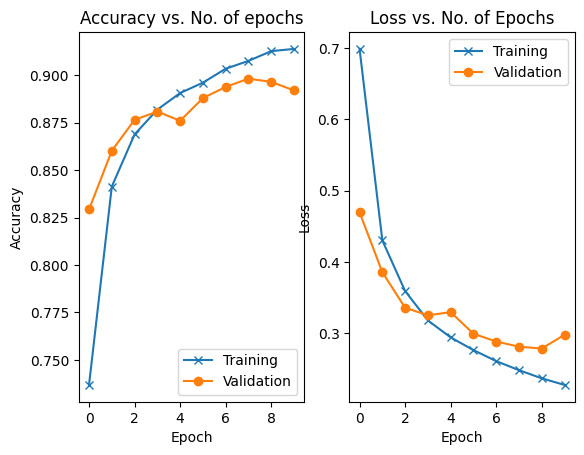

In [125]:
plot_accuracy(train_accuracies, val_accuracies)
plot_losses(train_losses, val_losses)

### Train a model on the entire dataset

In [126]:
indices, _ = split_indices(len(dataset), 0, rand_seed)

sampler = SubsetRandomSampler(indices)
dl = DataLoader(dataset, batch_size, sampler=sampler)

In [127]:
######################
#   YOUR CODE HERE   #
######################
num_epochs = 5 # Max number of training epochs
lr = 0.001 # Set the learning rate

In [128]:
model, _, _, _, _ = train_model(num_epochs, model, dl, [], loss_fn, opt_fn, lr)

ZeroDivisionError: division by zero

### Check Predictions
Now, you should evaluate your model on dataset. Specifically, you should calculate the class probabilities for each image, and then visualize these probabilities along with the image itself. Please include a function `view_prediction` in your code that takes an image, its label, the calculated probabilities, and the list of class names as input, and plots the image along with the probabilities.

In [ ]:
######################
#   YOUR CODE HERE   #
######################

### Save the model

In [ ]:
torch.save(model, 'model')

### Calculate accuracy on the test set

In [ ]:
test_dataset = FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
test_dl = DataLoader(test_dataset, batch_size)

In [ ]:
def evaluate(model, test_dl):
    """
    Evaluates your model on the test data.

    Args:
        model: ImageClassifierNet object
        test_dl: test dataloader

    Returns:
        Test accuracy.
    """
    ######################
    #   YOUR CODE HERE   #
    ######################

In [ ]:
print("Test Accuracy = {:.4f}".format(evaluate(model, test_dl)))